# Лабораторная работа 3

Обработка текстов.

Описание спортивных матчей (футольных, баскетбольных, хоккейных, волейбольных) с использованием специфичных терминов.

In [67]:
import pandas as pd
import numpy as np
import re
import nltk
import pymorphy3
import math
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

#### Преобразование данных

In [68]:
nltk.download("stopwords")

stopWords = stopwords.words("russian")
stopWords.append("это")

morph = pymorphy3.MorphAnalyzer(lang='ru')

def delete_stop_words(text):
    return [ word for word in text if word not in stopWords ]

def format_data(text):
    fmtTextStr = re.sub(
        r'[^\w\s]', 
        ' ', 
        text.lower(), 
        flags=re.UNICODE
    )
    tokenTextArr = nltk.word_tokenize(fmtTextStr)
    cleanTextArr = delete_stop_words(tokenTextArr)

    return " ".join(cleanTextArr)

def get_normal_form_str(line):
    return " ".join([
        morph.parse(word)[0].normal_form for word in line.split() 
        if morph.parse(word)[0].normal_form not in stopWords
    ])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirill/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Чтение данных

In [69]:
def read_files(filename, format):
    i = 1
    dataArr = []
    while True:
        try:
            fd = open(filename + str(i) + format, encoding="utf-8")
        except Exception:
            break
        
        dataArr.append([i, fd.read()])
        
        fd.close()
        i += 1

    return dataArr

footballArr = read_files("./data/football_", ".txt")
basketballArr = read_files("./data/basketball_", ".txt")
hockeyArr = read_files("./data/hockey_", ".txt")
volleyballArr = read_files("./data/volleyball_", ".txt")

In [70]:
dfFootball = pd.DataFrame(footballArr, columns=['num_doc', 'text'])
dfFootball["class"] = "football"

dfBasketball = pd.DataFrame(basketballArr, columns=['num_doc', 'text'])
dfBasketball["class"] = "basketball"

dfHockey = pd.DataFrame(hockeyArr, columns=['num_doc', 'text'])
dfHockey["class"] = "hockey"

dfVolleyball = pd.DataFrame(volleyballArr, columns=['num_doc', 'text'])
dfVolleyball["class"] = "volleyball"

dfDescriptions = pd.concat([dfFootball, dfHockey, dfVolleyball])
dfDescriptions.head(10)

,num_doc,text,class
0,1,Прошедший матч был настоящим шедевром футбольн...,football
1,2,В этом поединке встретились две команды с разн...,football
2,3,Этот матч был насыщен событиями с самого начал...,football
3,4,Этот матч был истинным испытанием для обеих ко...,football
4,5,В этом матче сила и техническое мастерство ста...,football
5,6,Этот матч был насыщен атмосферой напряжения и ...,football
6,7,В этой встрече соперничающие команды продемонс...,football
7,8,Этот поединок был истинным испытанием для кажд...,football
8,9,Этот матч представлял собой настоящий футбольн...,football
9,10,В этой встрече футбольные гении соперничали за...,football


#### TF-IDF

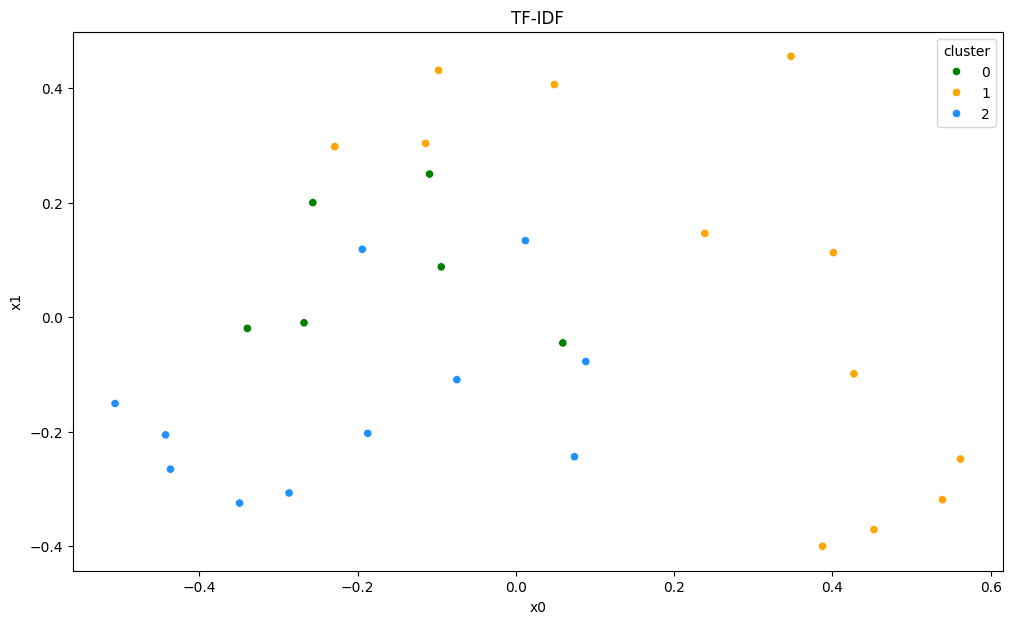

0.9166666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.83      0.91         6
           2       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.93      0.94      0.93        12
weighted avg       0.93      0.92      0.92        12



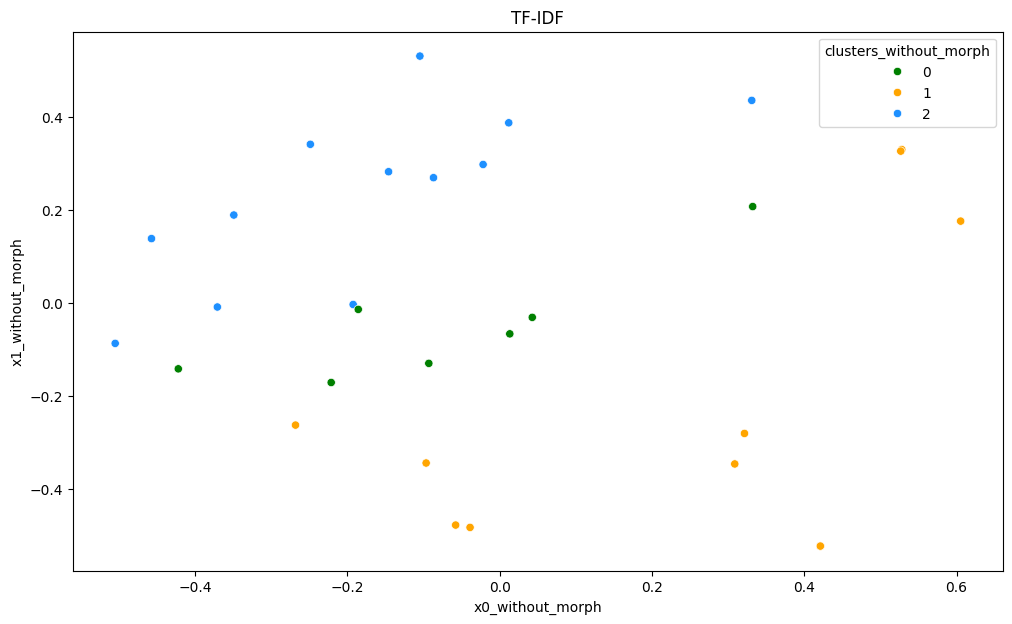

0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      1.00      0.89         4
           2       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.88      0.78      0.80        12
weighted avg       0.85      0.83      0.82        12



In [71]:
dfDescriptions["formated"] = dfDescriptions.text.apply(
    lambda textFTale: get_normal_form_str(format_data(textFTale))
)
dfDescriptions["formated_without_morph"] = dfDescriptions.text.apply(
    lambda textFTale: format_data(textFTale)
)

def _getVectorizer(fieldName):
    vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
    x = vectorizer.fit_transform(dfDescriptions[fieldName])
    return x

def _getClusters(x, fieldName):
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(x)
    clusters = kmeans.labels_
    dfDescriptions[fieldName] = clusters

def _pca(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x.toarray())
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    dfDescriptions[fieldX0] = x0
    dfDescriptions[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("TF-IDF")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(
        data=dfDescriptions, 
        x=fieldX0, 
        y=fieldX1, 
        hue=fieldCluster, 
        palette=['green', 'orange', 'dodgerblue']
    )
    plt.show()

def _calcAccuracy(x, fieldCluster):
    XVectorDf = pd.DataFrame(x.toarray())
    xTraining, xTest, yTraining, yTest = train_test_split(
        XVectorDf, 
        dfDescriptions[fieldCluster], 
        test_size=0.4,
        random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processTfIdf(fieldData, fieldCluster, fieldX0, fieldX1):
    X = _getVectorizer(fieldData)
    _getClusters(X, fieldCluster)
    _pca(X, fieldX0, fieldX1, fieldCluster)
    _calcAccuracy(X, fieldCluster)

processTfIdf('formated', 'cluster', "x0", "x1")
processTfIdf('formated_without_morph', 'clusters_without_morph', "x0_without_morph", "x1_without_morph")


#### Word2Vec

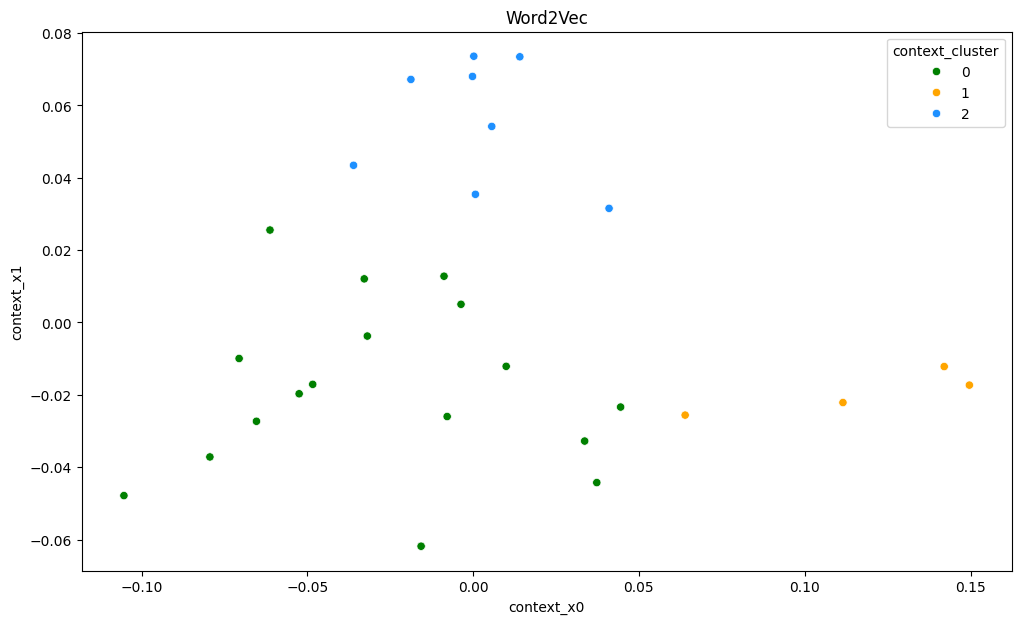

0.75
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         2
           2       1.00      0.50      0.67         4

    accuracy                           0.75        12
   macro avg       0.89      0.67      0.71        12
weighted avg       0.83      0.75      0.73        12



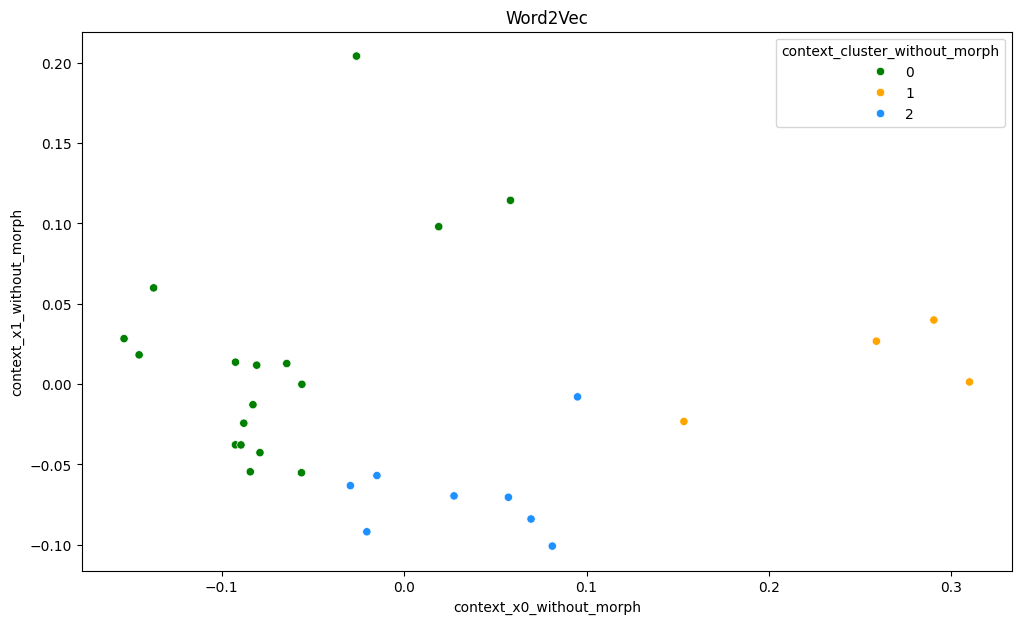

0.9166666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.50      0.67         2
           2       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.92      0.83      0.84        12
weighted avg       0.94      0.92      0.91        12



,num_doc,text,class,formated,formated_without_morph,cluster,x0,x1,clusters_without_morph,x0_without_morph,x1_without_morph,context_cluster,context_x0,context_x1,context_cluster_without_morph,context_x0_without_morph,context_x1_without_morph
0,1,Прошедший матч был настоящим шедевром футбольн...,football,прошедший матч настоящий шедевр футбольный иск...,прошедший матч настоящим шедевром футбольного ...,0,-0.256642,0.200117,2,-0.370639,-0.009336,0,-0.061261,0.025555,0,-0.087939,-0.024317
1,2,В этом поединке встретились две команды с разн...,football,поединок встретиться команда разный стиль игра...,поединке встретились две команды разными стиля...,0,-0.339338,-0.019621,1,-0.268029,-0.263161,2,0.000198,0.073602,0,-0.079073,-0.042623
2,3,Этот матч был насыщен событиями с самого начал...,football,матч насыщенный событие начало финальный свист...,матч насыщен событиями самого начала финальног...,2,-0.436548,-0.265684,2,-0.457163,0.137704,2,-0.000189,0.068017,2,-0.020481,-0.091844
3,4,Этот матч был истинным испытанием для обеих ко...,football,матч истинный испытание оба команда каждый игр...,матч истинным испытанием обеих команд каждый и...,2,-0.286665,-0.307264,2,-0.248541,0.340361,2,0.005617,0.054195,2,-0.014945,-0.056876
4,5,В этом матче сила и техническое мастерство ста...,football,матч сила технический мастерство сталкиваться ...,матче сила техническое мастерство сталкивались...,2,-0.506542,-0.150924,0,-0.421939,-0.142241,2,-0.036064,0.043448,0,-0.092518,-0.037767
5,6,Этот матч был насыщен атмосферой напряжения и ...,football,матч насыщенный атмосфера напряжение азарт оба...,матч насыщен атмосферой напряжения азарта обе ...,2,-0.442702,-0.205811,2,-0.504815,-0.087552,2,-0.018765,0.067185,0,-0.084367,-0.054527
6,7,В этой встрече соперничающие команды продемонс...,football,встреча соперничать команда продемонстрировать...,встрече соперничающие команды продемонстрирова...,2,-0.074604,-0.109302,2,-0.021692,0.297018,0,-0.007833,-0.025996,2,0.069540,-0.083895
7,8,Этот поединок был истинным испытанием для кажд...,football,поединок истинный испытание каждый игрок поле ...,поединок истинным испытанием каждого игрока по...,2,-0.194115,0.118595,2,-0.145833,0.281462,0,-0.070571,-0.009953,0,-0.056309,-0.055120
8,9,Этот матч представлял собой настоящий футбольн...,football,матч представлять настоящий футбольный триллер...,матч представлял собой настоящий футбольный тр...,2,-0.349217,-0.324947,2,-0.349041,0.188356,2,0.014079,0.073448,2,-0.029491,-0.063147
9,10,В этой встрече футбольные гении соперничали за...,football,встреча футбольный гений соперничать превосход...,встрече футбольные гении соперничали превосход...,1,-0.228812,0.297926,2,-0.192343,-0.003917,0,-0.105307,-0.047852,0,-0.080859,0.011781


In [72]:
def _get_w2vdf(fieldData):
    w2v_df = pd.DataFrame(dfDescriptions[fieldData]).values.tolist()
    for i in range(len(w2v_df)):
        w2v_df[i] = w2v_df[i][0].split(" ")
    return w2v_df

def _train_w2v(w2v_df):
    w2v_model = Word2Vec(min_count=1, vector_size=100)
    
    w2v_model.build_vocab(w2v_df)
    w2v_model.train(w2v_df, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)
    return w2v_model

def _preprocess(s):
    return [i for i in s.split()]

def _get_vector(s, model):
    return np.sum(np.array([model.wv[i] for i in _preprocess(s)]), axis=0)

def _pcaContext(x, fieldX0, fieldX1, fieldCluster):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    dfDescriptions[fieldX0] = x0
    dfDescriptions[fieldX1] = x1

    plt.figure(figsize=(12, 7))
    plt.title("Word2Vec")
    plt.xlabel(fieldX0)
    plt.ylabel(fieldX1)
    sns.scatterplot(
        data=dfDescriptions, 
        x=fieldX0, 
        y=fieldX1, 
        hue=fieldCluster, 
        palette=['green', 'orange', 'dodgerblue']
    )
    plt.show()

def _calcAccuracyContext(x, fieldCluster):
    XVectorDf = pd.DataFrame(x)
    xTraining, xTest, yTraining, yTest = train_test_split(
        XVectorDf, 
        dfDescriptions[fieldCluster], 
        test_size=0.4, 
        random_state=42
    )

    knn = KNeighborsClassifier(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(xTraining, yTraining)
    predictions = knn.predict(xTest).tolist()

    print(accuracy_score(yTest, predictions))
    print(classification_report(yTest, predictions))


def processContex(fieldData, fieldCluster, fieldX0, fieldX1):
    w2v_df = _get_w2vdf(fieldData)
    w2v_model = _train_w2v(w2v_df)

    x = [_get_vector(text, w2v_model) for text in dfDescriptions[fieldData]]
    x = normalize(x)

    _getClusters(x, fieldCluster)
    _pcaContext(x, fieldX0, fieldX1, fieldCluster)
    _calcAccuracyContext(x, fieldCluster)

processContex("formated", "context_cluster", "context_x0", "context_x1")
processContex("formated_without_morph", "context_cluster_without_morph", "context_x0_without_morph", "context_x1_without_morph")

dfDescriptions